
--- K-Nearest Neighbors ---

KNN Classification Report:
              precision    recall  f1-score   support

   Recovered       0.95      0.97      0.96       152
       Death       0.76      0.62      0.68        21

    accuracy                           0.93       173
   macro avg       0.86      0.80      0.82       173
weighted avg       0.93      0.93      0.93       173

Accuracy: 0.93
ROC-AUC: 0.94


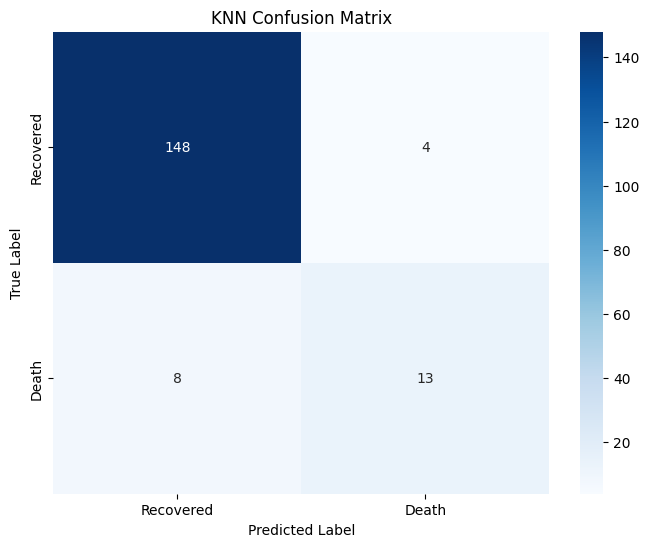


--- Logistic Regression ---

Logistic Regression Classification Report:
              precision    recall  f1-score   support

   Recovered       0.97      0.99      0.98       152
       Death       0.94      0.81      0.87        21

    accuracy                           0.97       173
   macro avg       0.96      0.90      0.93       173
weighted avg       0.97      0.97      0.97       173

Accuracy: 0.97
ROC-AUC: 0.99


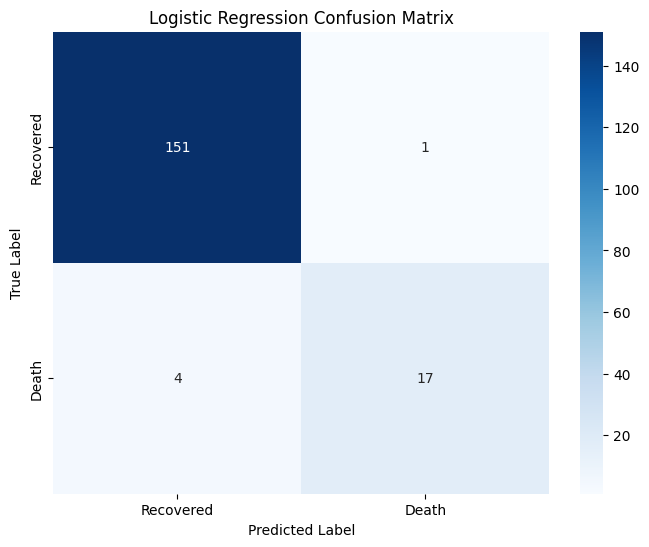


--- Naive Bayes ---

Naive Bayes Classification Report:
              precision    recall  f1-score   support

   Recovered       0.99      0.47      0.64       152
       Death       0.20      0.95      0.33        21

    accuracy                           0.53       173
   macro avg       0.59      0.71      0.49       173
weighted avg       0.89      0.53      0.60       173

Accuracy: 0.53
ROC-AUC: 0.71


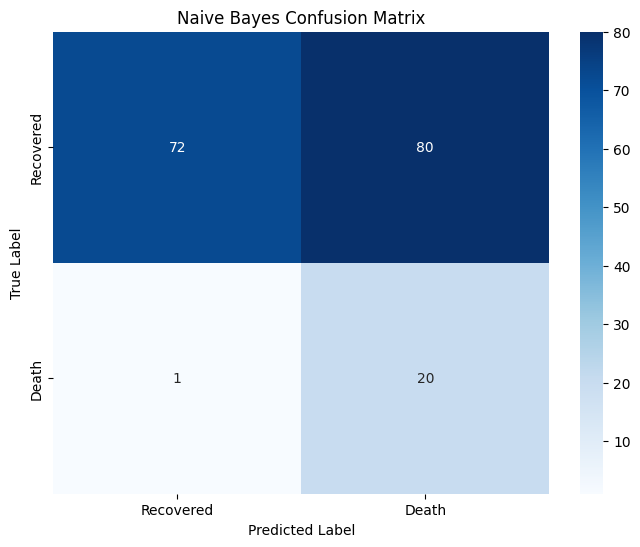


--- Decision Tree ---

Decision Tree Classification Report:
              precision    recall  f1-score   support

   Recovered       1.00      0.97      0.98       152
       Death       0.81      1.00      0.89        21

    accuracy                           0.97       173
   macro avg       0.90      0.98      0.94       173
weighted avg       0.98      0.97      0.97       173

Accuracy: 0.97
ROC-AUC: 0.99


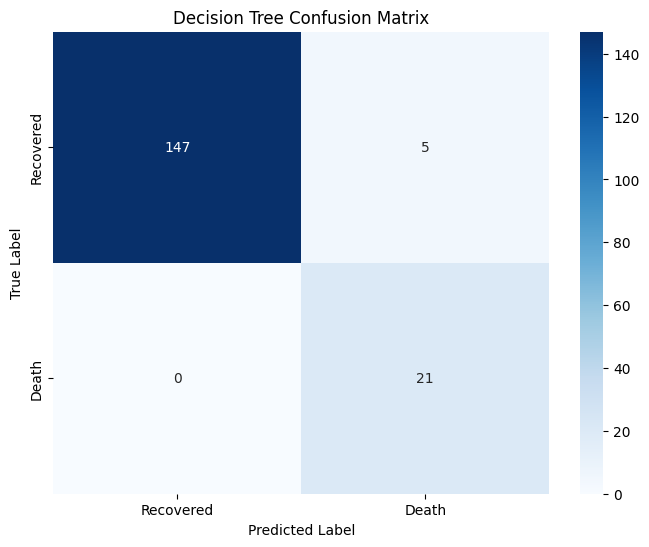


--- Support Vector Machine ---

SVM Classification Report:
              precision    recall  f1-score   support

   Recovered       0.97      0.97      0.97       152
       Death       0.77      0.81      0.79        21

    accuracy                           0.95       173
   macro avg       0.87      0.89      0.88       173
weighted avg       0.95      0.95      0.95       173

Accuracy: 0.95
ROC-AUC: 0.94


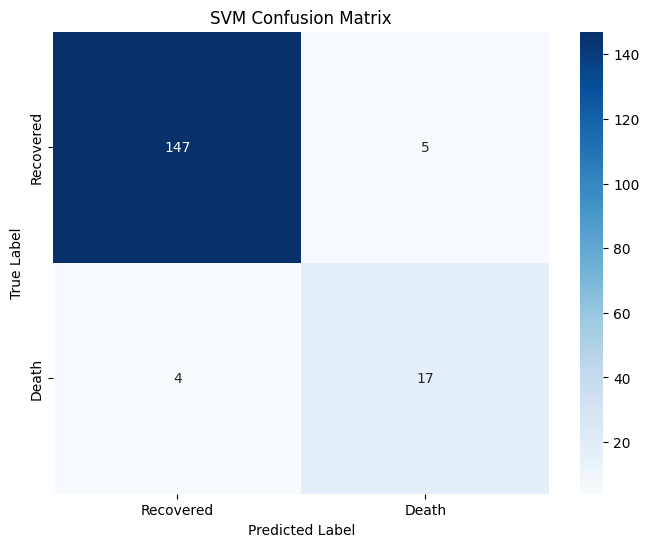


Final Model Comparison:
                 model  accuracy   roc_auc
3        Decision Tree  0.971098  0.994518
1  Logistic Regression  0.971098  0.991855
4                  SVM  0.947977  0.942356
0                  KNN  0.930636  0.940476
2          Naive Bayes  0.531792  0.713033


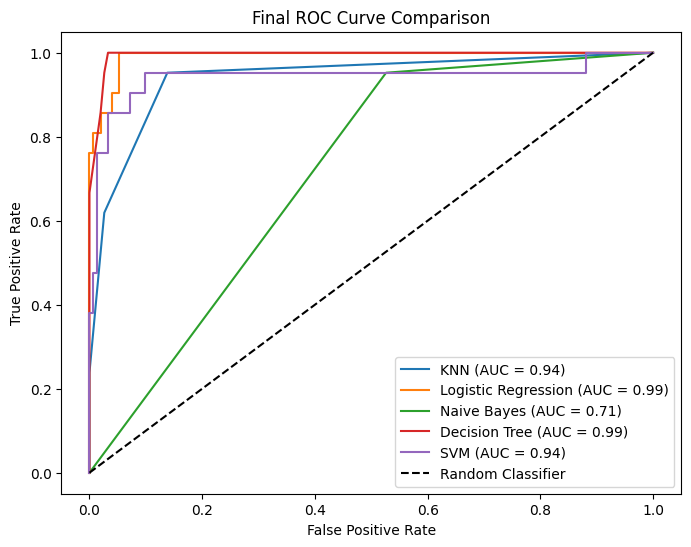

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv("data.csv")

# Feature Engineering and Preprocessing
# Drop irrelevant or unnamed columns if they exist
data = data.drop(columns=[col for col in data.columns if "Unnamed" in col], errors='ignore')

# Treat 'country' as a categorical variable (mapping integer codes to strings if needed)
# Assuming no mapping is provided, treat it as a categorical code
data['country'] = data['country'].astype(str)  # Convert to string for categorical processing

# Define features and target
X = data.drop(columns=['result'])  # Features (independent variables)
y = data['result']  # Target variable (dependent variable)

# Identify categorical and numerical columns
categorical_cols = ['country', 'location', 'gender', 'vis_wuhan', 'from_wuhan']  # Categorical features
numerical_cols = [col for col in X.columns if col not in categorical_cols]  # Numerical features

# Preprocessing pipeline
# Define transformations for categorical and numerical data
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)  # One-hot encode categorical variables and ensure dense output
numerical_transformer = StandardScaler()  # Standardize numerical variables

# Combine transformations in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),  # Apply numerical transformer to numerical columns
        ('cat', categorical_transformer, categorical_cols)  # Apply categorical transformer to categorical columns
    ]
)

# Split the data (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)  # Train/test split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)  # Validation/test split

# Function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Plot a confusion matrix with labels."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Function to evaluate a model
def evaluate_model(model, X_test, y_test, name):
    """Evaluate the given model and print metrics."""
    y_pred = model.predict(X_test)  # Predicted labels
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None  # Predicted probabilities if available
    
    # Generate classification report and metrics
    report = classification_report(y_test, y_pred, target_names=['Recovered', 'Death'], output_dict=True)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"  # Calculate ROC-AUC if probabilities are available
    
    # Confusion matrix and accuracy
    cm = confusion_matrix(y_test, y_pred)  # Confusion matrix
    accuracy = accuracy_score(y_test, y_pred)  # Overall accuracy

    # Print metrics and confusion matrix
    print(f"\n{name} Classification Report:\n{classification_report(y_test, y_pred, target_names=['Recovered', 'Death'])}")
    print(f"Accuracy: {accuracy:.2f}")
    if y_prob is not None:
        print(f"ROC-AUC: {roc_auc:.2f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, classes=['Recovered', 'Death'], title=f'{name} Confusion Matrix')
    
    return y_prob, roc_auc

# Initialize results storage
results = []  # Store evaluation results for all models
roc_curves = []  # Store ROC curves for plotting

# Helper function to build and evaluate models
def build_and_evaluate(model, params, model_name):
    """Build a pipeline, perform grid search for hyperparameter tuning, and evaluate the model."""
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])  # Create a pipeline
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)  # Grid search with cross-validation
    grid_search.fit(X_train, y_train)  # Fit the model
    best_model = grid_search.best_estimator_  # Retrieve the best model from grid search
    y_prob, roc_auc = evaluate_model(best_model, X_test, y_test, model_name)  # Evaluate the model
    results.append({
        'model': model_name,
        'accuracy': accuracy_score(y_test, best_model.predict(X_test)),
        'roc_auc': roc_auc
    })
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_curves.append((model_name, fpr, tpr, roc_auc))

# 1. K-Nearest Neighbors
print("\n--- K-Nearest Neighbors ---")
knn_params = {'classifier__n_neighbors': range(1, 21)}  # Range of neighbors to try
build_and_evaluate(KNeighborsClassifier(), knn_params, "KNN")

# 2. Logistic Regression
print("\n--- Logistic Regression ---")
logistic_params = {'classifier__C': [0.01, 0.1, 1, 10, 100], 'classifier__max_iter': [100, 200, 500]}  # Hyperparameter grid
build_and_evaluate(LogisticRegression(random_state=42), logistic_params, "Logistic Regression")

# 3. Naive Bayes
print("\n--- Naive Bayes ---")
nb_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GaussianNB())])  # Naive Bayes pipeline
nb_pipeline.fit(X_train, y_train)  # Train the Naive Bayes model
result = evaluate_model(nb_pipeline, X_test, y_test, "Naive Bayes")  # Evaluate the model
results.append({
    'model': "Naive Bayes",
    'accuracy': accuracy_score(y_test, nb_pipeline.predict(X_test)),
    'roc_auc': result[1]
})
if result[0] is not None:
    fpr, tpr, _ = roc_curve(y_test, result[0])
    roc_curves.append(("Naive Bayes", fpr, tpr, result[1]))

# 4. Decision Tree
print("\n--- Decision Tree ---")
dt_params = {'classifier__max_depth': [3, 5, 10, None], 'classifier__min_samples_split': [2, 5, 10]}  # Hyperparameter grid
build_and_evaluate(DecisionTreeClassifier(random_state=42), dt_params, "Decision Tree")

# 5. Support Vector Machine
print("\n--- Support Vector Machine ---")
svm_params = {'classifier__C': [0.1, 1, 10], 'classifier__gamma': [0.01, 0.1, 1], 'classifier__kernel': ['rbf']}  # Hyperparameter grid
build_and_evaluate(SVC(probability=True, random_state=42), svm_params, "SVM")

# Final Comparison Table
comparison_df = pd.DataFrame(results)  # Create a DataFrame for model comparison
comparison_df.sort_values(by='roc_auc', ascending=False, inplace=True)  # Sort by ROC-AUC

# Display comparison table professionally
print("\nFinal Model Comparison:")
print(comparison_df)

# Plot final ROC curves
plt.figure(figsize=(8, 6))
for model_name, fpr, tpr, roc_auc in roc_curves:
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC Curve Comparison')
plt.legend()
plt.show()
